In [1]:
# fit n number of frame in single representation
# model: HashNeRF(t,x,y)
# future: t, HashNeRF(x,y) ?
import os
import torch
import torchvision
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import imageio.v3 as iio
import numpy as np
import matplotlib.pyplot as plt
import time
import math
import random
from pathlib import Path
from tqdm import tqdm
from timeit import default_timer as timer
from array2gif import write_gif
print(torch.__version__)
torch.manual_seed(42)
np.random.seed(seed=42)
random.seed(42)
c_elegans = True


2.1.0


In [5]:

if c_elegans:
    vRead = iio.imread('data/c_elegans.mp4')
    video = np.array(vRead)
    print('video size: '+ str(len(video)))
    print('new video size: '+ str(len(video)))
    video = torch.as_tensor(video)
    testFrame = video[0]
    ### Crop letters from video
    croppedVideo = torch.zeros((2484, 270, 344,3)).type(torch.float32)
    for i in range(len(video)):
        croppedVideo[i] = video[i][18:288]
    #Normalize range of RGBs
    croppedVideo = torch.mul(croppedVideo, 1.0/255.0).type(torch.float32)
    video = croppedVideo[10:]
else:
    print("custom file input")
    #other custom file processing for later use
#Set device
print("Cuda available: ", torch.cuda.is_available())
if(torch.cuda.is_available()):
    torch.cuda.set_device("cuda:0")
    print("Is cuDNN version:", torch.backends.cudnn.version())
    print("cuDNN enabled:a", torch.backends.cudnn.enabled)
    print("Device count: ", torch.cuda.device_count())
    print("Current device: ", torch.cuda.current_device())
    print("Device name: ", torch.cuda.get_device_name(torch.cuda.current_device()))
#Setup device agnostic code (i.e use GPU if possible)
device = "cuda" if torch.cuda.is_available() else "cpu"
video = video.to(device)
print(device)



video size: 2484
new video size: 2484
Cuda available:  True
Is cuDNN version: 8700
cuDNN enabled:a True
Device count:  3
Current device:  0
Device name:  NVIDIA RTX A6000
cuda


In [6]:

class hashNerf3D(nn.Module):
    def __init__(self,
                input_shape: int,  # Update to 3 for 3D coordinates
                hidden_units: int,
                output_shape: int,
                L=16, T=2**16, F=2, N_min=8, N_max=256, num_output=3):
        self.L = L
        self.T = T
        self.F = F
        self.N_min = N_min
        self.N_max = N_max
        self.num_output = num_output
        super().__init__()

        b = np.exp((np.log(self.N_max) - np.log(self.N_min)) / (self.L - 1)) # scalar : dim 1
        self.N_values = torch.floor(torch.tensor(np.float32(self.N_min * b ** np.arange(self.L)))).type(torch.int64).to(device) # dim : 16,1
        temp_hash_table = torch.FloatTensor(L,T,F).uniform_(-1e-4, 1e-4) # dim : L, T, F
        self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))
        self.vertices = torch.transpose(torch.tensor([
                        [0, 0, 0],
                        [0, 0, 1],
                        [0, 1, 0],
                        [0, 1, 1],
                        [1, 0, 0],
                        [1, 0, 1],
                        [1, 1, 0],
                        [1, 1, 1]]), 0, 1).type(torch.float32).to(device) 
        self.prime_numbers = torch.tensor([1, 2654435761, 805459861]).type(torch.int64).to(device)

        self.layer_stack = nn.Sequential(
            nn.Linear(input_shape, hidden_units),
            nn.LeakyReLU(),
            nn.Linear(hidden_units, output_shape),
            nn.ReLU()
        ).to(device)

    def forward(self, X):
        X = X.to(device)
        ##print("X shape:", X.shape)
        x_scaled = X[:, :, None] * self.N_values[None, None, :]
        #print("x_scaled shape:", x_scaled.shape)
        x_floor = torch.floor(x_scaled)
        #print("x_floor shape:", x_floor.shape)
        x_ceil = torch.ceil(x_scaled)
        #print("x_ceil shape:", x_ceil.shape)
        #x_vertices = torch.zeros((len(x_floor), 3, self.L, 8)).to(device)
        #print("x_vertices shape:", x_vertices.shape)
        x_vertices = x_floor[:, :, :, None] * self.vertices[None, :, None, :]
        #print("x_vertices updated shape:", x_vertices.shape)
        x_vertices = x_vertices.type(torch.int64)
        
        primesTemp = torch.tensor([1, 2654435761, 805459861]).type(torch.int64).to(device)
        x_to_hash_temp = x_vertices * primesTemp[None, :, None, None]
        #print("x_to_hash_temp shape:", x_to_hash_temp.shape)

        x_hash_temp = torch.bitwise_xor(
                        torch.bitwise_xor(x_to_hash_temp[:, 0],
                                            x_to_hash_temp[:, 1]),
                            x_to_hash_temp[:, 2])
        #print("x_hash_temp shape:", x_hash_temp.shape)
        x_hash_temp = torch.remainder(x_hash_temp, self.T) 
        x_hash = x_hash_temp
        #print("x_hash shape:", x_hash.shape)
        x_hash = x_hash.to(device)
        x_hash = x_hash.permute(1, 0, 2)
        #print("x_hash permuted shape:", x_hash.shape)
        lookup = torch.stack([self.hash_table[i][x_hash[i]] for i in range(self.L)], dim=0).to(device)
        #print("lookup shape:", lookup.shape)
        lookup = lookup.permute(1,0,2,3)
        #print("lookup permuted shape:", lookup.shape)
        
        weights = x_scaled - x_floor
        #print("weights shape:", weights.shape)
        fx = weights[:, 0, :]
        cx = 1 - fx
        fy = weights[:, 1, :]
        cy = 1 - fy
        fz = weights[:, 2, :]
        cz = 1 - fz
        
        f111 = fx * fy * fz  
        f110 = fx * fy * cz
        f101 = fx * cy * fz
        f100 = fx * cy * cz
        f011 = cx * fy * fz
        f010 = cx * fy * cz
        f001 = cx * cy * fz
        f000 = cx * cy * cz
        f_stack = torch.stack([f000, f001, f010, f011, f100, f101, f110, f111], dim=2)
        #print("f_stack shape:", f_stack.shape)
        x_interp = torch.sum(f_stack[:, :, :, None] * lookup, dim=2)
        #print("x_interp shape:", x_interp.shape)
        x = x_interp.reshape(-1, self.L * self.F)
        #print("x shape after reshape:", x.shape)
        
        return self.layer_stack(x.to(device).type(torch.float32))

  

In [7]:
# Data Loader
class MultiImageDataset(Dataset):
    def __init__(self, video_tsr, s, e, transform=None, target_transform=None):
        self.video = video_tsr.type(torch.float32)
        self.transform = transform
        self.target_transform = target_transform
        self.s = s
        self.e = e
    def __len__(self):
        return self.video.shape[0] * self.video.shape[1] * self.video.shape[2]
    def __getitem__(self, idx):
        f = 1.0 * idx // (self.video.shape[1] * self.video.shape[2])
        r = idx % (self.video.shape[1] * self.video.shape[2])
        row = r // self.video.shape[2]
        col = r % self.video.shape[2]
        image = self.video[int(f)]
        #label = pixel 
        pixel = torch.as_tensor(image[int(row)][int(col)]).type(torch.float32).to(device)
        row = row / (image.shape[0])
        col = col / (image.shape[1])
        return torch.as_tensor([f/len(video), row, col]).type(torch.float32).to(device), pixel


In [9]:
  
    
## Utils
import math
from pathlib import Path
def PSNR(MSELoss, max):
    return (20*math.log10(max)) - (10*math.log10(MSELoss))

"""
def saveModel(modelPointer, psnr_note=35, frameNumber=0):
    # 1. Create models directory - won't create if it exists
    MODEL_PATH = Path("c_elegans_models")
    MODEL_PATH.mkdir(parents=True, exist_ok=True)
    MODEL_NAME = "hash_nerf_frame_"+str(frameNumber)+"_psnr_"+str(psnr_note)+".pth"
    MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
    MODEL_SAVE_PATH
    print(f"Saving model to: {MODEL_SAVE_PATH}")
    torch.save(obj=modelPointer.state_dict(),
            f=MODEL_SAVE_PATH)
    print(MODEL_SAVE_PATH)
    return MODEL_SAVE_PATH
"""
"""
def saveImage(frame_note, psnr_note=39):
    x_test_T = torch.as_tensor(croppedVideo[100])
    reconstruction_input_matrix = torch.zeros(croppedVideo[100].shape[0], croppedVideo[100].shape[1], 2).type(torch.float32)
    #encode coordinates into debug matrix
    for i in range(0, x_test_T.shape[0]):
        for j in range(0, x_test_T.shape[1]):
            reconstruction_input_matrix[i][j] = torch.as_tensor([i/(video.shape[1]-3.0),j/(video.shape[2]-3.0)]).type(torch.float32)
    reconstruction_input_matrix = torch.flatten(reconstruction_input_matrix, 0, 1)
    model_0.eval()
    with torch.inference_mode():
        reconstruction = model_0(reconstruction_input_matrix).cpu()
        reconstruction = reconstruction.reshape((croppedVideo[100].shape[0], croppedVideo[100].shape[1],3))
        reconstruction = torch.mul(reconstruction, 255.0).type(torch.int32)
        plt.imshow(reconstruction)
        plt.axis(False)
        plt.savefig("c_elegans_reconstructions_naive/hash_nerf_reconstruction_frame_"+str(frame_note)+"_psnr_"+str(psnr_note)+".png", bbox_inches="tight", pad_inches=0.0)
        plt.close()
"""


numFrames = 1 # now number of segments of k frames

time_series = np.zeros((numFrames+1, 6), dtype=float) # numFrames * (initial, 25, 27.5, 30, 35, 40)
epoch_series = np.zeros((numFrames+1, 6), dtype=float) # numFrames * (initial, 25, 27.5, 30, 35, 40)
loss_series =  np.zeros((numFrames+1, 6), dtype=float)


loss_at_epoch = []
psnr_at_epoch = []

time_series[0] = np.array([0, 25, 27.5, 30, 35, 40])
epoch_series[0] = np.array([0, 25, 27.5, 30, 35, 40])
loss_series[0] = np.array([0, 25, 27.5, 30, 35, 40])



k = 10 # num of frames to fit per NeRF
v_start = 0
v_end = v_start+k-1
model_0 = hashNerf3D(32, 128, 3)

for t in range(0, numFrames):
    model_0.train()
    training_data = MultiImageDataset(video[v_start:v_end], v_start, v_end)
    train_loader = DataLoader(training_data, batch_size=2**18, shuffle=True)
    #params
    lr1 = 0.01
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(params=model_0.parameters(), lr=lr1, eps=10e-15)
    # Training Loop
    start = timer()
    PSNR_thresh = 50
    batchCount = 0
    psnr_table = []
    psnr_table_epochs = []
    savedAt25 = False
    savedAt27_5 = False
    savedAt30 = False
    savedAt35 = False
    savedAt39 = False
    exit_loop = False

    #same model used all time - i.e. weights carry over
    for epoch in tqdm(range(0, 2000)):
        if exit_loop:
            break
        model_0.train()
        for batch in iter(train_loader):
            batchCount += 1
            y_train = torch.as_tensor(batch[1]).to(device)
            y_train = torch.squeeze(y_train)
            X = torch.tensor(batch[0]).type(torch.float32)
            y_train = torch.as_tensor(y_train).type(torch.float32)
            # Forward Pass
            y_pred = model_0(X).to(device).type(torch.float32)
            loss = loss_fn(y_pred, y_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if loss == 0:
            print("done")
        psnr = PSNR(loss, 1.0)
        psnr_table.append(psnr)
        if epoch % 1 == 0:
            print(f"Epoch: {epoch} | LR: {lr1} | Train loss: {loss} | PSNR: {psnr}")
        loss_at_epoch.append(loss)
        psnr_at_epoch.append(psnr)
        if epoch == 0:
            time_series[t+1][0] = 0
            epoch_series[t+1][0] = epoch
            loss_series[t+1][0] = loss
        if (savedAt25 == False) and (psnr >= 25) and (psnr < 30):
            endT = timer()
            time_series[t+1][1] = endT - start
            epoch_series[t+1][1] = epoch
            loss_series[t+1][1] = loss
            #saveImage(t, 25)
            savedAt25 = True
        elif (savedAt27_5 == False) and (psnr >= 27.5) and (psnr < 30):
            endT = timer()
            time_series[t+1][2] = endT - start
            epoch_series[t+1][2] = epoch
            loss_series[t+1][2] = loss
            #saveImage(t, 25)
            savedAt27_5 = True
        elif (savedAt30 == False) and (psnr >= 30) and (psnr < 39):
            #lr1 = lr1/1000
            endT = timer()
            time_series[t+1][3] = endT - start
            epoch_series[t+1][3] = epoch
            loss_series[t+1][3] = loss
            #saveImage(t, 30)
            savedAt30 = True
        elif (savedAt35 == False) and (psnr >= 35) and (psnr < 39):
            #lr1 = lr1/10
            endT = timer()
            time_series[t+1][4] = endT - start
            epoch_series[t+1][4] = epoch
            loss_series[t+1][4] = loss
            #saveImage(t, 30)
            savedAt35 = True
        elif (psnr >= PSNR_thresh):
            endT = timer()
            time_series[t+1][5] = endT - start
            epoch_series[t+1][5] = epoch
            loss_series[t+1][5] = loss
            #saveImage(t, PSNR_thresh)
            exit_loop = True
            break
    end = timer()
    time_elapsed = end - start
    
    print('time: ', str(time_elapsed))
    print('Training Finished')
    #Plot PSNR
    plt.ylim(0, 65)
    plt.plot(range(0,len(psnr_table)), psnr_table)
    plt.title('Train PSNR - (skipping 20 frames) Frames:' + str(v_start)+ " to "+ str(v_end))
    plt.ylabel('PSNR')
    #NOT EPOCHS - THESE ARE BATCHES!!!
    plt.xlabel('Epoch')
    plt.savefig("c_elegans_psnr_plots_3D2/zero_start_hash_nerf_reconstruction_frames_"+ str(v_start)+ "_to_"+ str(v_end)+".png", bbox_inches="tight")
    plt.close()
    v_start = v_end + 1
    v_end += k

loss_at_epoch = torch.tensor(loss_at_epoch).cpu().numpy()
psnr_at_epoch = torch.tensor(psnr_at_epoch).cpu().numpy()
f = k

/tmp/ipykernel_1881334/1130627440.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.hash_table = nn.Parameter(torch.tensor(temp_hash_table.clone(), requires_grad=True).to(device).type(torch.float32))
  0%|          | 0/2000 [00:00<?, ?it/s]/tmp/ipykernel_1881334/682378063.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(batch[0]).type(torch.float32)
  0%|          | 1/2000 [00:55<30:45:57, 55.41s/it]

Epoch: 0 | LR: 0.01 | Train loss: 0.04703964293003082 | PSNR: 13.275359835753243


  0%|          | 2/2000 [01:48<29:58:10, 54.00s/it]

Epoch: 1 | LR: 0.01 | Train loss: 0.03895993530750275 | PSNR: 14.093817729335122


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


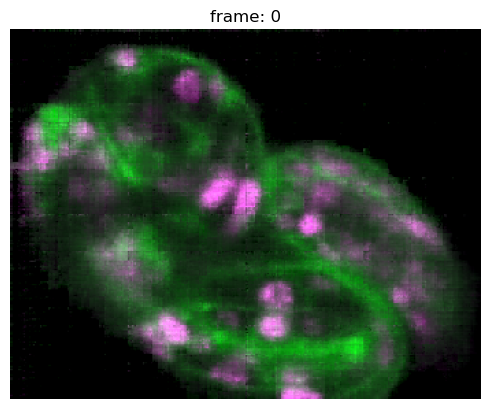

In [137]:

x_test_T = torch.as_tensor(croppedVideo[100])
gif_reconstruct_mat = np.empty((f, croppedVideo.shape[1], croppedVideo.shape[2], 3))
#encode coordinates into debug matrix
for t in range(0, 1):
    for i in range(0, x_test_T.shape[0]):
        for j in range(0, x_test_T.shape[1]):
            x_test_T[i][j] = torch.as_tensor([t/len(video), i/(video.shape[1]-0),j/(video.shape[2]-0)]).type(torch.float32)
    reconstruction_input_matrix = torch.flatten(x_test_T, 0, 1)

    model_0.eval()
        
    with torch.inference_mode():
        reconstruction = model_0(reconstruction_input_matrix).cpu()
        reconstruction = reconstruction.reshape((croppedVideo[100].shape[0], croppedVideo[100].shape[1], 3))
        #reconstruction = torch.mul(255, reconstruction).type(torch.int32)
        gif_reconstruct_mat[t] = reconstruction.numpy()
        plt.axis(False)
        plt.title('frame: ' + str(t))
        plt.savefig("c_elegans_reconstructions_3D/hash_nerf_3D_DEBUG_reconstruction_frame_"+str(t)+ ".png", bbox_inches="tight", pad_inches=0.0)
        plt.imshow(reconstruction)

# write_gif(gif_reconstruct_mat, 'c_elgans_gif.gif', fps=30)